# Run ABM simulations

In general, ABM is a ‘bottom-up’ systems modelling approach from which emerging properties arise from the interaction of constituent parts. In this study,  these agents and interactions are set up in a way that simulates processes and produces outcome measurements.

In this notebook we run the Agent-Based Model Simulation of a Hospital in order to **ascertain the distribution of bed numbers needed to meet patient demand** over a long period of time. The design of the Agent Based Model is summarised in the diagram below.

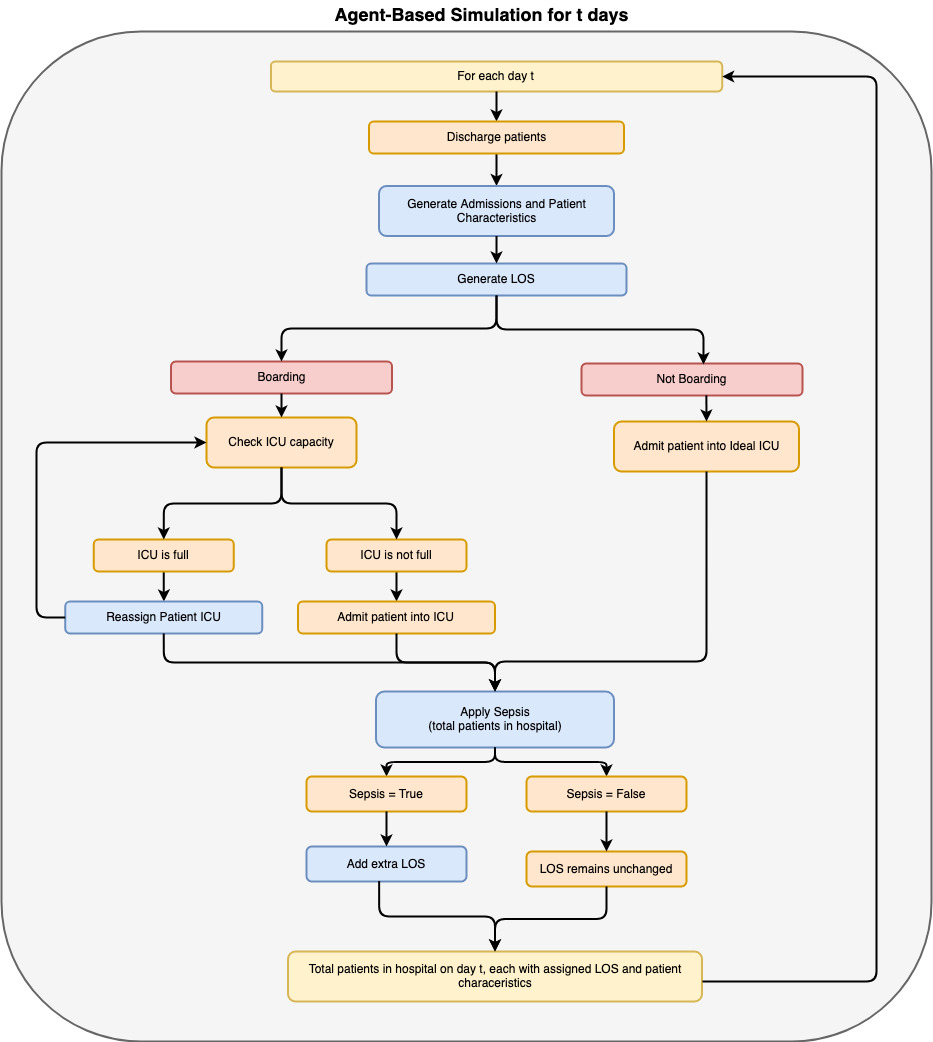

In [2]:
from IPython.display import Image
Image("abm_boarding_notbayes.jpg")

Beth Israel Deaconess Medical Center's (BIDMC’s) Intensive Care Unit (ICU) system was modelled with the agents being individual patients, assigned characteristics of ideal ICU unit, actual ICU unit (if ideal unit is over capacity), cluster indicating distinct length of stay distribution and sepsis flag. 

The **sources of stochasticity** for this model (blue boxes in the diagram) are:
- Admissions distributions
- Length of Stay Prediction
- Likelihood of developing Sepsis
- Reassigning a patient if their preferred ICU is full
- Extending LOS if
These distributions are prepared in the Admissions_dists_estimation folder and are estimated from the Beth Israel Deaconess Medical Center admissions data from 2001-2012.

The **emerging properties** of this model are:
- Number of beds required to meet patient demand at individual ICU level
- Number of beds required to meet patient demand at whole hospital level

The **setup of the simulations** are as follows:
 - We run each model for 1100 days before restarting the simulation. 
 - Only days 100- 1100 are counted to allow time for the model to reach steady state. 
 - This is repeated to obtain a distribution across multiple runs, which allows us to create 95\% confidence intervals for each run and average the Confidence intervals across those runs. 
 - For each set of results using the static distributions, we run 1000 simulations over 1000 days.
- In accordance with the recommended best practices for Agent-Based Modelling by Hammond \cite{Hammond2015}, we have chosen to work with a simplistic model (no boarding, no Bayes updates, no admission scenarios), to generate results before adding in greater complexity. This allows the modeller to maintain clarity about how each piece of the model affects results, and can greatly facilitate interpretation.

We are interested in the sensitivity of our bed estimates to small permanent shifts in the admissions distributions, achieved by changing fixed parameters relating to the admissions distributions in a way that mimics plausibly realistic situations. **4 different scenarios** are modelled:
   - No scenario
   - Pollen scenario ; A sustained period of pollen levels classified as ‘high,’ which has been shown to cause up to a 17.23\% increase in hospital admissions due to asthma (Osborne, Nicholas J. et al. 2017). This was added to the Agent-Based Simulation as binomial draw (p= 0.03, equivalent to 17.23\% of the 626 patients over 4170 days for our dataset) that determined  whether an additional asthma patient with Length of Stay of 4 days (Hoskins 2000) was additionally ‘admitted’ to the hospital every day.
   - Pollution scenario; A sustained increase in pollution, which causes increased hospital cardiovascular admissions (Schwartz, Joel and Morris, Robert 1995)- the 85th percentile level of CO levels for example, results in 4\% higher cardiovascular ICU admissions. This was added to the Agent-Based Simulation as a binomial draw (p = 0.025, equivalent to 4\% higher CV admissions for the 2625 non-surgical cardiac patients over 4170 days in our dataset) that determined if a patient with Length of Stay of 6 days (Linn, W S and Szlachcic, Y et al. 2000) was additionally ‘admitted’ to the hospital every day
   - Heat scenario; Prolonged period of heat, which causes an increase of 16\% of admissions in the over 75s and and increase of 4\% admissions in the under 75s (UK_national_health_statistics). This was added to the Agent-Based simulation as a binomial draw every for each ICU/cluster combination with these probabilities converted into distributions relevant for our dataset i.e. adjusted to represent the number of over 75s and under 75s present.
    
The **contents** of this notebook is:
1. Load libraries and files
2. Prepare stochastic distributions
3. Define hospital models
4. Run peactime (no scenario) simulations
5. Run scenario simulations

# 1.1 Load libraries

In [4]:
import numpy as np
import pandas as pd
import pickle
import os
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from datetime import timedelta
import math
import random
import pickle
from collections import defaultdict
import random
from collections import Counter

# 1.2 Load files

In [9]:
#Set directory
with open('/.../dprob_list.pkl', 'rb') as f:
    group_prob_list = pickle.load(f)

# Hospital Length of Stay distributions representing probability of staying given number of days for each of the 4 clusters
los_probs = pd.read_csv('/.../los_probability_df.csv')

los_probs.head()

,1,2,3,4
0,0.664609,0.059841,0.026316,0.000000
1,0.203704,0.124609,0.026316,0.000000
2,0.061728,0.150204,0.026316,0.000000
3,0.037037,0.153329,0.052632,0.000000
4,0.016461,0.147921,0.078947,0.037736


In [11]:
os.chdir('/.../processed_data')
clustered_data = pd.read_csv('clustered_data_for_priors.csv').drop('Unnamed: 0', axis=1) # Patient details including cluster and 
                                                                                         # predicted Length of Stay

sepsis_los_icu_df = pd.read_csv('sepsis_los_icu_df.csv') # Length of Stay distributions for patients with sepsis

os.chdir("/.../processed_data")
add_ads = pd.read_csv('add_ads.csv') # Additional admissions associated with scenarios

# 2. Probabilities and distributions

In this section we prepare the parameters for the admissions, length of stay and sepsis distrbutions that constitute the stochastic parts of the Agent Based Model.

In [17]:
#Functions

def normalize(df):
    '''#to make sure multinomial draw for each cluster (column) sums to 1 '''
    for column in df.columns:
        df[column] = df[column] / sum(df[column])
    return df


def draw_from(probabilities):
    '''function for multinomial draw with input as a probability dataframe'''
    counts = list(map(lambda x: int(x), probabilities.index))
    cases = sum(np.random.multinomial(n=1, pvals= probabilities) * counts)
    return cases


def draw_boolean(dist):
    '''#function for drawing whether patient has sepsis or whether dod_exists (date of death) exists (=True or False)'''
    import random
    return random.random() < dist


class SepsisModel():
    """
    #create class for Sepsis Model to do both look ups
    p_dist   - chance of getting sepsis by day, e.g day 0 -> 0%, day 20 -> 18%
    los_dist - icu mean increase by icu, e.g SICU -> 9.5
    """
    def __init__(self, p_dist, los_dist):
        self.p_dist = p_dist
        self.los_dist = los_dist
        
    def check_sepsis(self, time_in_hospital, icu):
        ''' Returns a los increment if patient gets sepsis, returns 0 otherwise'''
        chance_of_sepsis = self.p_dist[time_in_hospital]
        if random.random() < chance_of_sepsis:
            # patient got sepsis
            return self.los_dist[icu]
        return 0

In [28]:
# Implement: Prepare stochastic distributions

'''1) Convert counts to probabilties for Length of Stay distributions. 
 The result is a table of parameters describing a multinomial distribution for each patient type (cluster). 
 The multinomial distribution is distributed over different, discrete, length of hospital stay, in days.'''
los_probs =  normalize(los_probs)

'''2) Take ideal ICU in place of actual ICU to correct for boarding
In the original patient data, some patients are placed in an ICU that is not the ideal one given their requirements- this could 
be due to the original being full etc. In the data preparation steps we estimate the ICU a patient **should** have been admitted under
and assign them to this _ideal_ ICU, which is taken in place of the actual ICU here.  This allows us to get a true idea of what the
demand for a given ICU should be, rather than what it was in reality'''
clustered_data['correct_icu'] = clustered_data['FIRST_CAREUNIT'] == clustered_data['ideal_ICU']

'''3)  Make icu boarding probabilities in table called icu_probabilities 
Here we create a table of probabilities by which to reassign patients to other ICUs if their preferred ICU is over capacity.
This is not needed in these simulations as we are interested in the number of beds required to meet patient demand if _no_ 
interventions are made.'''
icu_mapping = clustered_data[clustered_data['correct_icu'] == False][['ideal_ICU', 'FIRST_CAREUNIT', 'cluster_number']]
icu_mapping = icu_mapping[(icu_mapping['ideal_ICU'] != 'unknown') & (icu_mapping['FIRST_CAREUNIT'] != 'unknown')]
icu_mapping.columns = list(map(lambda x: x.lower(), icu_mapping.columns))
icu_mapping['count'] = 1
mappings = icu_mapping.groupby(['cluster_number', 'first_careunit', 'ideal_icu']).count()
totals = icu_mapping.drop('first_careunit', axis=1).groupby(['cluster_number', 'ideal_icu']).count()
icu_probabilities = (mappings / totals).reset_index()

'''4) Turn distribution above into a dictionary, to be able to look up easily'''
increment = 0.01125
index = 3
maximum = 0.18
sepsis_dist = defaultdict(lambda: maximum)
sepsis_dist[0] = 0
sepsis_dist[1] = 0
sepsis_dist[2] = 0
aggregate = 0
while aggregate < maximum:
    aggregate += increment
    sepsis_dist[index] = aggregate
    index += 1
    
''' 5) # # create a lookup table (global) for sepsis; this allows us to look up what the impact of developing sepsis is on the 
Length of Stay of a patient staying in each ICU.'''
sepsis_los_by_icu = sepsis_los_icu_df.to_dict()
sepsis_los_by_icu = { k: v for k, v in list(zip(sepsis_los_by_icu['icu'].values(), sepsis_los_by_icu['mean_los'].values())) }

''' 6) '''
sepsis_model_dist = SepsisModel(sepsis_dist, sepsis_los_by_icu)
sepsis_df = clustered_data[clustered_data['sepsis']]

''' 7) Date of death mapping'''
dod_mapping = clustered_data[['ideal_ICU', 'cluster_number', 'sepsis', 'dod_exists']]
dod_mapping.columns = list(map(lambda x: x.lower(), dod_mapping.columns))
dod_mapping['count'] = 1
dod_mapping = dod_mapping.groupby(['sepsis', 'cluster_number', 'ideal_icu']).sum()
dod_mapping['prob_death'] = dod_mapping['dod_exists'] / dod_mapping['count']
dod_mapping = dod_mapping.drop(['dod_exists', 'count'], axis=1)


''' 8) #create a dictionary called death_lookup which will be used in hospital model (twice)
The format is (sepsis, cluster_number, ideal_icu)
The first time dict is used:
    - When a patient is admitted (sepsis=False, cluster_number, and assigned icu), we will draw from that probability the likelihood 
    they will die at the end of their LOS
The second time dict is used:
    - in apply_sepsis; when patient gets sepsis, their prob of death changes based on this dictionary '''
death_lookup = dod_mapping.to_dict()['prob_death']

In [5]:
# Perform Checks

# 1) first column in first ICU (= probability of 0-6 people admitted in group1 )
print("1) Admission probabilities")
print("Sum of 0-6 people admitted in group one for first ICU is", group_prob_list[0]['1'].sum() )

# 1) looking at l#looking at length of stay prob, per group
print("LOS probs head", los_probs.head(15)) #length of stay prob, per group

# 3) 
print(' ')
print("3) ICU probabilties")
print(icu_probabilities.head())
print("Column names of clustered data", clustered_data.columns)

#4) 
print(' ')
print("4) likelihood of getting sepsis depending on number of days you have been in hospital")
print('mean los icu: ', clustered_data['los_icu'].mean()) #with and without sepsis mean los = 4
print('mean los icu when sepsis=True: ',clustered_data[clustered_data['sepsis']]['los_icu'].mean()) #with sepsis mean los = 8
print('mean los icu when sepsis=False: ',clustered_data[clustered_data['sepsis']==False]['los_icu'].mean()) #without sepsis mean los = 4

#5) 
print(' ')
print("5) examples of prob of getting sepsis dictionary")
print("day 2", sepsis_dist[2]) #prob on day 2
print("day 3", sepsis_dist[3]) #prob on day 3
print("day 18", sepsis_dist[18]) #prob on day 18
print("day 19", sepsis_dist[19]) #prob on day 19
print("day 20", sepsis_dist[20]) #prob on day 20
# after drawing from probability of sepsis dictionary from above this is the number of days los will be extended if sepsis=True
print("Sepsis LOS ICU df")
print(sepsis_los_icu_df.head())

#6) 
print(' ')
print("6) Sepsis model distribution")
print(sepsis_model_dist)
#Probability of death by grouping dod_exists into icu, cluster number, and sepsis
print('probability of death when sepsis=True or sepsis=False:', len(clustered_data[clustered_data['dod_exists']])/len(clustered_data)) #38% dod exists = True
print('probability of death when sepsis=True: ',len(sepsis_df[sepsis_df['dod_exists']])/len(sepsis_df)) #61% dod_exists = True when sepsis = True
print('probability of death when sepsis=False: ', len(sepsis_df[sepsis_df['dod_exists']==False])/ len(sepsis_df)) #39% dod_exists when sepsis=False

# 8) 
print(' ')
print("8) Death lookup")
print(death_lookup)

1) Admission probabilities
Sum of 0-6 people admitted in group one for first ICU is 1.0
LOS probs head            1         2         3         4
0   0.664609  0.060247  0.017544  0.000000
1   0.203704  0.125454  0.017544  0.000000
2   0.061728  0.151222  0.017544  0.000000
3   0.037037  0.154367  0.035088  0.000000
4   0.016461  0.148923  0.052632  0.029412
5   0.016461  0.110331  0.017544  0.014706
6   0.000000  0.077063  0.070175  0.014706
7   0.000000  0.060489  0.070175  0.088235
8   0.000000  0.040286  0.035088  0.102941
9   0.000000  0.026373  0.017544  0.014706
10  0.000000  0.017542  0.052632  0.029412
11  0.000000  0.010283  0.070175  0.058824
12  0.000000  0.005565  0.052632  0.029412
13  0.000000  0.003750  0.052632  0.044118
14  0.000000  0.002057  0.035088  0.044118
 
3) ICU probabilties
   cluster_number ideal_icu first_careunit     count
0               1       CCU           CSRU  0.750000
1               1       CCU           MICU  0.250000
2               1      CSRU 

# 3.  Define Hospital ABM Model

Here we define the core classes and functions associated with our Agent Based Model.

Class **Patient** is the basic unit of the ABM and has associated core characteristics including Length of Stay, Sepsis and Date of Death flag

Class **NonBayesAdmissionsModel** generates admissions for each day, adding additional admissions according to scenario, and then adds draws or assigns a Length of Stay to these new patients according to cluster and adds this patient to the hospital.

Function **GetValue** returns a value from a list or dictionary

Class **HospitalModel** enables the core functioning of the Agent Based Model, including discharge processes, movement between ICU, sepsis draws and death draws for each patient as well as the retrieval of dataframes for eviction, admission and patient details that allows us to study the emerging properties of the model. 

Function **ForICU** subsets a dataframe by ICU.

In [6]:
# Define classes and functions

class Patient:
    '''The basic unit of our ABM; each patient has associated characteristics of LOS, ICU, group, DOD flag, sepsis flag, patient ID, 
    and these get updated every day that the model runs for'''
    ID = 0    
    
    def __init__(self, original_los, admission_day, group, icu, dod_exists = False):
        '''Initialise core characteristics of each patient'''
        self.id = Patient.ID
        Patient.ID += 1
        original_los = round(original_los)
        self.original_los = original_los
        self.remaining_los = original_los
        self.admission_day = admission_day
        self.icu = icu
        self.group = group
        self.dod_exists = dod_exists
        self.sepsis_exists = False #here I initialise sepsis exists = False for every admission
    
    #always returns this info about a created patient
    def __repr__(self):
        return f'Patient({vars(self)})'


class NonBayesAdmissionsModel():
    """
    Wraps a dictionary of { day: [patients] }. An entry from the dictionary can be retrieved using
    model.admit(day). e.g model.admit(day = 2) -> patients for day 2
    """
    def __init__(self, icu_list, group_prob_list, scenario):
        """A simple model with precomputed admissions based on:
        icu_list - the list of ICUs
        group_probs - a dataframe specifying group probabilities
        """
        for day in day_range:
            admissions = []
            for i, icu in enumerate(icu_list):
                group_probs = group_prob_list[i] # Probability of x # of inpatients per day by group

                # Define ICU-specific daily diagnosis probability vectors and LOS dictionary
                for group in group_probs.columns:  
                    # calculate new cases by day
                    new_cases = draw_from(group_probs[group])
                    
                    # POLLEN: Add extra patients in case of pollen scenario
                    if scenario == "pollen" and group == '2' and icu == 'MICU':
                        if np.random.binomial(1, (1/33)) == 1:
                            patient = Patient(
                                original_los = 4,
                                admission_day = day,
                                icu = icu,
                                group = group
                            )
                            admissions.append(patient)
        
                    # POLLUTION: Add extra patients in case of pollution scenario 
                    if scenario == "pollution" and group == '2' and icu == 'CCU':
                        if np.random.binomial(1, (1/40)) == 1:
                            patient = Patient(
                                original_los = 6,
                                admission_day = day,
                                icu = icu,
                                group = group
                            )
                            admissions.append(patient)
                            
                    # HEAT: Add extra patients in case of heat scenario
                    if scenario == 'heat' and group == '1':
                        if np.random.binomial(1, add_ads.loc[i, 'total']):
                            patient = Patient(
                                original_los = add_ads.loc[i, 'LOS'],
                                admission_day = day,
                                icu = icu,
                                group = group
                            )
                            admissions.append(patient)
                        
                    
                    # print(f'{icu} {group} {new_cases}')
                    for case in range(int(new_cases)):
                        LOS = draw_from(los_probs[str(group)])
                        patient = Patient(
                            original_los = LOS,
                            admission_day = day,
                            icu = icu,
                            group = group
                        )
                        admissions.append(patient)
            patients[day] = admissions
            self.patients = patients
            
    def admit(self, day):
        return self.patients.get(day, [])
    
    def last_day(self):
        return max(self.patients.keys())

    
def get_value(d, k):
    if k in d:
        return d[k]
    return []

default_icu_capacities = {
    'CCU': 6,
    'CSRU': 6,
    'MICU': 16,
    'NICU': 20,
    'SICU': 16,
    'TSICU': 10
}

class HospitalModel:
    """
    sepsis_model: call check_sepsis(days_in_hospital, icu) to get a LOS update (0 for no sepsis)
    """
    def __init__(self, admissions_model, model_name, icu_capacities=default_icu_capacities, sepsis_model=None,admission_method='choose'):
        self.admissions_model = admissions_model
        self.admission_method = admission_method
        self.evicted = {} #records all discharged patients (evicted through los_ended or patient_died)
        self.hospital = {} #all patients currently in hospital, for a given day
        self.admissions = {} # admissions for a given day
        self.icu_capacities = icu_capacities
        self.icu_n_patients = { icu: 0 for icu in icu_capacities.keys() }
        self.day = 0
        self.model_name = model_name
        self.sepsis_model = sepsis_model

    def __repr__(self):
        return f'HospitalModel(name={self.model_name}, sepsis_model={self.sepsis_model})'
    
    '''return dataframes functions
    dataframe functions for getting all results '''
    def add_time_in_hospital(self, df):
        df['time_in_hospital'] = df['day'] - df['admission_day']
    
    def df(self, name):
        if name == 'hospital':
            return self.hospital_df()
        elif name == 'evicted':
            return self.evicted_df()
        elif name == 'admissions':
            return self.admissions_df()
        else:
            raise Exception(f'df of {name} not found')
    
    #def filter_cols(self, df):
    #    return df.drop(['dod_exists', 'reason'], axis = 1)
    
    def admissions_df(self):
        '''Returns dataframe of number of patients admitted every day'''
        results = []
        for day, patients in self.admissions.items():
            for patient in patients:
                patient_record = vars(patient)
                patient_record['day'] = day
                results.append(patient_record)
        return pd.DataFrame(results)
        
    
    def evicted_df(self):
        '''Returns dataframe of number of patients discharged every day'''
        results = []
        for day, patients in self.evicted.items():
            for patient in patients:
                patient_record = deepcopy(patient)
                patient_record['day'] = day
                results.append(patient_record)
        df = pd.DataFrame(results)
        self.add_time_in_hospital(df)
        return df.drop(['dod_exists', 'reason'], axis = 1)
    
    
    def hospital_df(self):
        '''Returns full results dataframe'''
        results = []
        for day, patients in self.hospital.items():
            for patient in patients:
                patient_dict = vars(patient)
                patient_dict['day'] = day
                results.append(patient_dict)
        df = pd.DataFrame(results)
        self.add_time_in_hospital(df)
        return df.drop('dod_exists', axis=1)
    
    '''Simulation functions'''
    def discharge(self, patient, reason):
        '''when called: process patient, discharge reason is recorded, and added to evicted dictionary'''
        patient_discharge_record = vars(patient) # get patients attributes as a dictionary
        patient_discharge_record['reason'] = reason
        self.icu_n_patients[patient.actual_icu] -= 1
        self.evicted[self.day].append(patient_discharge_record)
        
    def process_patient(self, patient):
        '''calculate remaining los for each day'''
        if patient.admission_day != self.day:
            patient.remaining_los -= 1
        
        # each branch in if loop models a different outcome for the patient on the given day
        # if the patient los is 0 of less and if dod_exists = True they leave the hospital and flagged as patient_died
        if patient.remaining_los <= 0 and patient.dod_exists == True:
            self.discharge(patient, 'patient_died')
        elif patient.remaining_los <= 0:
            #if patient with dod_exists=False, they leave hospital and flagged as los_ended
            self.discharge(patient, 'los_ended')
        #otherwise, the patient stays in the hospital
        else:
            self.hospital[self.day].append(patient)
            
    # old sepsis version
    def apply_sepsis(self): 
        '''process patients getting sepsis 
        #randomly select that number of patients from those in hospital, 
        #change sepsis_exists from False to True
        #remaining_los + 10'''
        if self.sepsis_model:
            for patient in self.hospital[self.day]:
                if not patient.sepsis_exists:
                    days_in_hospital = self.day - patient.admission_day
                    los_increase = self.sepsis_model.check_sepsis(days_in_hospital, patient.actual_icu)
                    if los_increase > 0:
                        patient.sepsis_exists = True
                        patient.remaining_los += los_increase
                        
                        # recalculate if they'd die (if they weren't already going to die)
                        if not patient.dod_exists:
                            patient.dod_exists = draw_boolean(death_lookup[(True, int(patient.group), patient.actual_icu)])
        
    def icu_is_full(self, icu):
        '''Check if ideal ICU is full or if patient needs to be reassigned'''
        return self.icu_n_patients[icu] >= self.icu_capacities[icu]
    
    def choose(self, probabilities):
        '''Reassign to new ICU when previous ICU is full'''
        import random
        probabilities = probabilities.to_dict()
        icus = []
        pvals = []
        # only include icus which aren't full
        for index, icu in probabilities['first_careunit'].items():
            if not self.icu_is_full(icu):
                icus.append(icu)
                pvals.append(probabilities['count'][index])
        # if all icus are full return None - there is no alternative
        if len(icus) == 0:
            return None
        # otherwise pick from the remaining icus
        return random.choices(icus, pvals)[0]
    
    def admit_patient(self, patient):
        '''Add new patients to ICU'''
        if self.admission_method == 'choose':
            if self.icu_is_full(patient.icu):
                # if the ICU is full, board the patient in another icu
                desired_icu = self.choose(icu_probabilities)
                desired_icu = desired_icu if desired_icu else patient.icu
            else:
                # otherwise the patient goes to their ICU
                desired_icu = patient.icu
        else:
            desired_icu = patient.icu
            
        patient.actual_icu = desired_icu
        # probability of death is related to sepsis, cluster, and actual icu
        patient.dod_exists = draw_boolean(death_lookup[(False, int(patient.group), patient.actual_icu)])
        # increase the count for the icu the patient ends up in by 1
        self.icu_n_patients[patient.actual_icu] += 1
        return patient
        
        
    def next_day(self):
        '''combine patients remaining from previous day with new admissions that day'''
        previous_days_patients = get_value(self.hospital, self.day - 1)
        self.admissions[self.day] = list(map(self.admit_patient, self.admissions_model.admit(self.day)))
        all_patients = deepcopy(previous_days_patients + self.admissions[self.day])
        
        #empty lists for current day's evictions and people in hospital. patients are added/processed in next step
        self.hospital[self.day] = []
        self.evicted[self.day] = []
        
        #patients are processed (either stay, die, discharge)
        for patient in all_patients:
            self.process_patient(patient)
            
        self.apply_sepsis()
        
        #error checking. each patient only has one outcome in process_patient function
        if len(self.hospital[self.day]) + len(self.evicted[self.day]) != len(all_patients):
            raise Exception(f'Some patients had more than one outcome {self.hospital[self.day]} {self.evicted[self.day]}')
            
#         print(f'ran day {self.day}')
        self.day += 1
        
    def simulate(self, n_days):
        '''Run model'''
        for _ in range(n_days):
            self.next_day()
            
    def simulate_to_end(self):
        ''' to check for bugs:
    Checks how long model runs if no new admissions and wait for everyone to be discharged  '''
        while len(self.hospital.get(self.day - 1, [])) != 0 or self.day < self.admissions_model.last_day():
            self.next_day()
            
def for_icu(df, icu):
    '''Subset dataframe based on ICU'''
    return df[df['actual_icu'] == icu]

# 4. Run Non-Bayes simulations - No scenario

Here we run the Agent Based Model Simulation under "peacetime", normal scenario. 

In [17]:
# Initialise and define parameters

# exception_LOS = 4 # LOS used when LOS is NAN
patients = {}
Patient.ID = 0

num_days = 1100 # Number of days the model should run for in each rep
day_range = range(0, num_days)
warm_start = 99 # Days after start of model to commence measurement
num_reps = 1000 # Number of repetitions
icus = ['CCU', 'CSRU', 'NICU', 'MICU', 'TSICU', 'SICU']

ci_interval = 0.025 # Between 0-1, at what intervals should confidence levels be calcualted

In [18]:
rep_results = []

for R in range(0, num_reps):
    
    # Define admissions model
    non_bayes_admissions = NonBayesAdmissionsModel(icus,
                                               group_prob_list,
                                               scenario = None)

    # Define overall ABM model with admissions models embedded
    non_bayes_hospital_no_boarding = HospitalModel(admissions_model = non_bayes_admissions, 
                                               model_name = 'non_bayes', 
                                               admission_method = 'Non-boarding',
                                               sepsis_model= sepsis_model_dist)

    # Run simulation
    non_bayes_hospital_no_boarding.simulate(n_days= num_days)

    # Create df with admissions distributions for each ICU
    rep_results.append(non_bayes_hospital_no_boarding.hospital_df())

# View
rep_results[0].tail()

,id,original_los,remaining_los,admission_day,icu,group,sepsis_exists,actual_icu,day,time_in_hospital
103652,14875,3,3.0,1099,MICU,2,False,MICU,1099,0
103653,14876,9,9.0,1099,MICU,2,False,MICU,1099,0
103654,14877,1,1.0,1099,NICU,1,False,NICU,1099,0
103655,14878,2,2.0,1099,SICU,2,False,SICU,1099,0
103656,14879,6,6.0,1099,SICU,2,False,SICU,1099,0


In [14]:
# Convert results df into something plottable!

# Loop through all repetitions to create one list of days for each ICU
icu_counts = [[], [], [], [], [], []]

for R in range(0, num_reps):
    
    df = rep_results[R]

    for i, icu in enumerate(icus):

        icu_df = for_icu(df, str(icu))
        index = range(0, max(df['day']))
        counts = icu_df.groupby('day').size().reindex(index, fill_value=0)
        counts = counts[warm_start:num_days]
        
        for c in counts:
            icu_counts[i].append(c)
 
# Add up all days with given number of patients to get number of days with a given number of patients
count_df = np.zeros([6, 100])

for i, icu in enumerate(icus):
    
    count_dict = Counter(icu_counts[i])
    
    for key, value in count_dict.items():
        
        count_df[i][key] = value
        
count_df = pd.DataFrame(count_df).transpose()
count_df.columns = icus

# Record CI intervals
ci_range = np.arange(0, 1 + ci_interval, ci_interval)

cis_per_icu = np.zeros([6, len(ci_range)])

for i, icu in enumerate(icus):
    
    df = icu_counts[i]

    for j, ci in enumerate(ci_range):
        
        cis_per_icu[i][j] = np.quantile(df, ci)

cis_per_icu = pd.DataFrame(cis_per_icu)
cis_per_icu.index = icus
cis_per_icu.columns = ci_range

# Save files
os.chdir('/.../graphs')

with open('cis_pericu_peace3.pkl', 'wb') as f:
       pickle.dump(cis_per_icu, f)
        
with open('barcounts_pericu_peace3.pkl', 'wb') as f:
       pickle.dump(count_df, f)
        
with open('counts_peace3.pkl', 'wb') as f:
       pickle.dump(icu_counts, f)

In [15]:
cis_per_icu

,0.000,0.025,0.050,0.075,0.100,0.125,0.150,0.175,0.200,0.225,...,0.775,0.800,0.825,0.850,0.875,0.900,0.925,0.950,0.975,1.000
CCU,0.0,4.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,...,12.0,13.0,13.0,13.0,14.0,14.0,15.0,16.0,17.0,26.0
CSRU,0.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,5.0,...,9.0,9.0,9.0,10.0,10.0,11.0,11.0,12.0,13.0,25.0
NICU,6.0,13.0,14.0,15.0,16.0,17.0,17.0,18.0,18.0,19.0,...,26.0,27.0,27.0,28.0,28.0,29.0,30.0,31.0,33.0,49.0
MICU,9.0,22.0,24.0,25.0,26.0,27.0,28.0,28.0,29.0,29.0,...,39.0,40.0,40.0,41.0,42.0,43.0,44.0,45.0,48.0,67.0
TSICU,0.0,5.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,8.0,...,13.0,13.0,14.0,14.0,15.0,15.0,16.0,16.0,18.0,27.0
SICU,0.0,5.0,5.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,...,13.0,13.0,14.0,14.0,14.0,15.0,16.0,16.0,18.0,30.0


# 5. Run simulations -SCENARIOS

Here we run our ABM hospital model under different scenarios (see intro for description)

In [45]:
# Define parameters
num_reps = 200 # How many times to repeat each scenario 
num_days = 1100 # Number of days in each simulation
warm_start = 99 # How long to allow simlation to approach steady state before measurement

scenarios = ['None', 'pollen', 'pollution', 'heat']

In [ ]:
all_results = []

for scen in scenarios: # Loop for every scenario
    
    scen_results = []
    
    for sim in range(0, num_reps): # Loop for all repeats
        
    
        non_bayes_admissions = NonBayesAdmissionsModel(icu_list, group_prob_list, scenario = scen)
        non_bayes_hospital = HospitalModel(non_bayes_admissions,
                                           model_name ='non_bayes',
                                           admission_method = 'Non-boarding',
                                           sepsis_model= sepsis_model_dist)
        non_bayes_hospital.simulate(n_days= num_days) 

        
        scen_results .append(non_bayes_hospital.hospital_df())
    
    all_results.append(scen_results)
    


In [38]:
# CALCULATE per ICU 95CIs and record distributions for plotting

all_cis = []
all_counts = []

for i in range(0, len(all_results)): # Loop over all scenarios
    
    scen_cis = np.zeros([6, num_reps])
    scen_counts = [[], [], [], [], [], []]
    
    for j in range(0, num_reps): # Loop over all simulations
        
        for k, icu in enumerate(icus): # Loop over all ICUs
            
            df = all_results[i][j].loc[all_results[i][j].loc[:, 'icu'] == icu, ]
            df = df.loc[df.loc[:, 'day'] >= warm_start, ]
            counts = df.groupby('day').id.count()
            scen_cis[k][j] = np.quantile(counts, 0.95)
            for c in counts:
                scen_counts[k].insert(0, c)
            
    all_cis.append(np.mean(scen_cis, axis = 1))
    scen_counts = pd.DataFrame(scen_counts)
    scen_counts.index = icus
    all_counts.append(scen_counts)
    
all_cis = pd.DataFrame(all_cis)
all_cis.columns = icus
all_cis.index = scenarios


# Per ICU CIs for service level plotting

ci_interval = 0.025
ci_range = np.arange(0, 1 + ci_interval, ci_interval)

all_scen_res = []

for s, scen in enumerate(scenarios):
    
    sc_df = all_counts[s]
      
    cis_per_icu = np.zeros([6, len(ci_range)])

    for i, icu in enumerate(icus):

        sc_icu_df = sc_df.loc[icu, :].dropna()

        for j, ci in enumerate(ci_range):

            cis_per_icu[i][j] = np.quantile(sc_icu_df, ci)

    cis_per_icu = pd.DataFrame(cis_per_icu)
    cis_per_icu.index = icus
    cis_per_icu.columns = ci_range
    
    all_scen_res.append(cis_per_icu)
    

# Whole hospital counts 
wh_counts = np.zeros([4, all_counts[0].shape[1]]) 

for i in range(0, len(all_counts)):
            
    sc_df = all_counts[i] 
    
    for j, icu in enumerate(sc_df.index):
        
        if icu != 'NICU':
        
            sc_icu_df = sc_df.loc[icu, :]

            wh_counts[i] += sc_icu_df
        
wh_counts = [pd.DataFrame(x).dropna() for x in wh_counts]
 
# All WH CIs for service level plotting

all_scen_wh_cis =np.zeros([4, len(ci_range)])

for s, scen in enumerate(scenarios):
    
    sc_df = wh_counts[s]
      
    for j, ci in enumerate(ci_range):

        all_scen_wh_cis[s][j] = np.quantile(sc_df, ci)

all_scen_wh_cis = pd.DataFrame(all_scen_wh_cis)
all_scen_wh_cis.index = scenarios
all_scen_wh_cis.columns = ci_range
    
# Save results
os.chdir('/.../scenarios_runs')

with open('all_results_scenarios3.pkl', 'wb') as f:
       pickle.dump(all_results, f)
        
with open('95_cis_scenarios3.pkl', 'wb') as f:
       pickle.dump(all_cis, f)
        
with open('all_counts_scenarios3.pkl', 'wb') as f:
       pickle.dump(all_counts, f)

with open('all_cis_scenarios3.pkl', 'wb') as f:
       pickle.dump(all_scen_res, f)
        
with open('wh_counts_scenarios3.pkl', 'wb') as f:
       pickle.dump(wh_counts, f)
        
with open('wh_cis_scenarios3.pkl', 'wb') as f:
   pickle.dump(all_scen_wh_cis, f)